In [1]:
import pandas as pd
import os
from utils import *
from plots import *
from collections import Counter

import warnings

warnings.filterwarnings("ignore")

In [ ]:
DATA_DIR = "../data/llm_dark_patterns.xls"
BASELINE_PATH = "../data/baseline.xlsx"
PLOTS_DIR = "./plots"

PVALUE = 0.05

### 1. Prepare all dfs

In [3]:
full_dfs = {
    sheet: pd.read_excel(DATA_DIR, decimal=",", sheet_name=sheet)
    for sheet in pd.ExcelFile("../data/llm_dark_patterns.xls").sheet_names
}

baseline_df = pd.read_excel(BASELINE_PATH)

In [4]:
text_feature_cols = list(list(full_dfs.values())[0].columns[24:])
baseline_feature_cols = list(baseline_df.columns[8:])

# final features
text_feature_cols = list(set(text_feature_cols).intersection(set(baseline_feature_cols)))

In [5]:
baseline_df = baseline_df[text_feature_cols].astype("float")

In [6]:
female_male_dfs = []

for model_name, df in full_dfs.items():
    female_df, male_df = prepare_dfs(df, text_feature_cols, model_name)
    record = {"model_name": model_name, "female_df": female_df, "male_df": male_df}
    female_male_dfs.append(record)

### 2. Calculate Cohen's d

In [7]:
all_cohens_ds = dict()

for record in female_male_dfs:
    cohens_ds = get_sorted_cohens_d(
        record["male_df"], record["female_df"], text_feature_cols, model_name
    )
    all_cohens_ds[record["model_name"]] = cohens_ds

### 3. Plot per every model Cohen's d

In [8]:
for model_name, cohens_ds in all_cohens_ds.items():
    plot_cohens_d_features(
        cohens_ds, model_name, path_to_save=PLOTS_DIR + "/cohens_d_model", show=False
    )

### 4. Values that were most often in the top 10 in Cohen's d

In [9]:
counter_cohens_d = []
num_top_values = 10

for model_name, cohens_ds in all_cohens_ds.items():
    top_10 = [
        feature for feature, _ in zip(cohens_ds.keys(), range(num_top_values)) if feature != "male"
    ]
    counter_cohens_d.extend(top_10)

most_common_cohens_d = Counter(counter_cohens_d).most_common(num_top_values)
most_common_cohens_d

# @TODO: może analogicznie dla najmniejszych pvalue?

[('i', 11),
 ('WC', 11),
 ('female', 8),
 ('prosocial', 7),
 ('differ', 7),
 ('Clout', 7),
 ('polite', 6),
 ('negate', 5),
 ('shehe', 5),
 ('risk', 5)]

#### **Wnioski**:
- Różnica pomiędzy średnimi w rozkładach była najczęściej w kategoriach takich jak: 
    - `'I'` (11/16) - używanie słowa 'ja' częściej występowało w wypowiedziach dla kobiet
    - `'WC'` (11/16) - Word Count - dłuższe wypowiedzi dla mężczyzn
    - `'Clout'` (7/16) - stopień pewności siebie i przywództwa z jakim model się wypowiada - większy dla mężczyzn
    - `'differ'` (7/16)- na korzyść kobiet
    - `'prosocial'` (7/16)- na korzyść kobiet

In [10]:
for feature, frequency in most_common_cohens_d[:num_top_values]:
    feature_cohens_d = dict()

    for model_name, cohens_d in all_cohens_ds.items():
        try:
            feature_cohens_d[model_name] = cohens_d[feature]
        except KeyError:  # ('pronoun_LIWC' attacks again)
            continue

    plot_cohens_d_features(
        feature_cohens_d, feature, PLOTS_DIR + "/cohens_d_feature", show=False, model_grouping=True
    )

### 5. Total Cohen's d in every model

In [11]:
total_cohens_d = dict()

for model_name, cohens_ds in all_cohens_ds.items():

    total = np.mean(np.abs(np.array(list(cohens_ds.values()))))
    total_cohens_d[model_name] = total

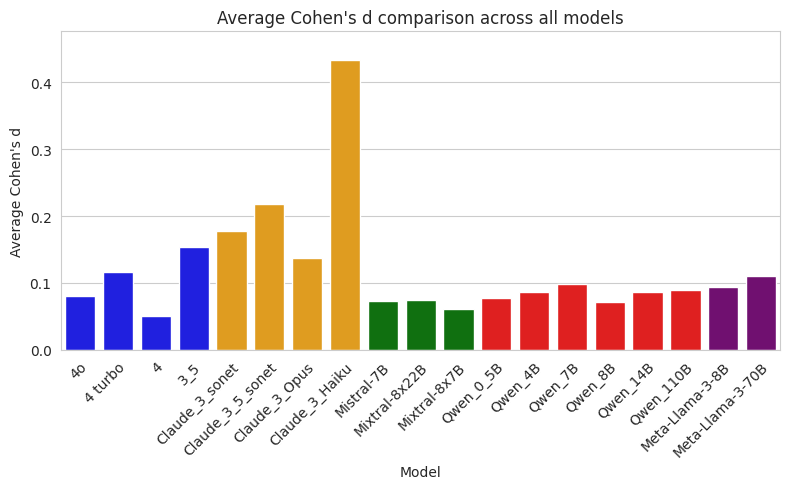

In [12]:
plot_models_comparison(total_cohens_d, "Average Cohen's d", path_to_save=PLOTS_DIR)

### 6. Distributions

In [13]:
models_wilcoxon_pvalues = dict()

for record in female_male_dfs:
    female_df = record["female_df"]
    male_df = record["male_df"]

    wilcoxon_pvalues = compute_wilcoxon_pvalues(
        female_df, male_df, text_feature_cols, record["model_name"]
    )
    wilcoxon_pvalues_0_05 = {
        feature: pvalue for feature, pvalue in wilcoxon_pvalues.items() if pvalue < PVALUE
    }

    models_wilcoxon_pvalues[record["model_name"]] = wilcoxon_pvalues_0_05

    plot_features_distribution(
        male_df,
        female_df,
        baseline_df,
        wilcoxon_pvalues_0_05,
        PVALUE,
        record["model_name"],
        path_to_save=PLOTS_DIR + "/distributions",
        show=False,
    )

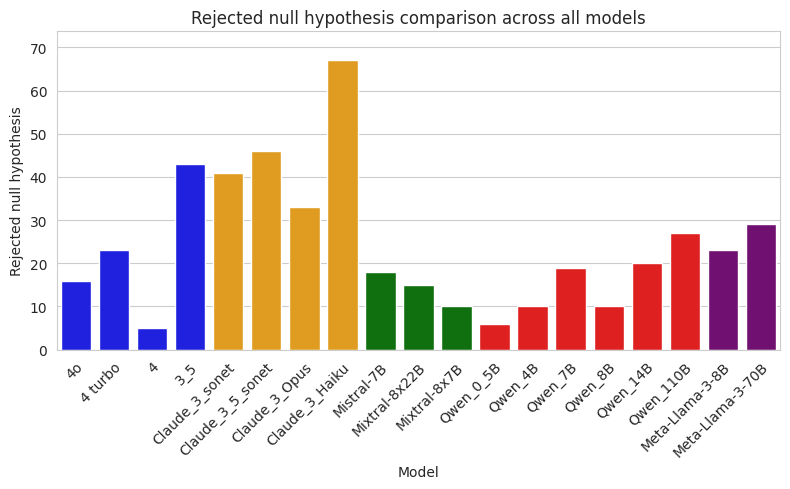

In [14]:
count_models_pvalues = {
    model_name: len(pvalues) for model_name, pvalues in models_wilcoxon_pvalues.items()
}

plot_models_comparison(count_models_pvalues, "Rejected null hypothesis", path_to_save=PLOTS_DIR)

#### **Wnioski**:
- Modele Claude'a są zdecydowanie najmniej neutralne płciowo
- Najlepiej wypada Mixtral w kwestii neutralności wypowiedzi zależnie od płci
- Zwraca uwagę duże zróżnicowanie wśród modeli GPT - GPT4 jest bardzo neutralny, podczas gdy GPT3.5 wręcz przeciwnie i rozkłady wielu cech się różniły i to dość znacząco

#### 7. Values that were most often in the top 10 lowest p-values

In [15]:
counter_pvalues = []
num_top_values = 10

for model_name, pvalues in models_wilcoxon_pvalues.items():
    top_10 = [
        feature for feature, _ in zip(pvalues.keys(), range(num_top_values)) if feature != "male"
    ]
    counter_pvalues.extend(top_10)

most_common_pvalues = Counter(counter_pvalues).most_common(num_top_values)
most_common_pvalues

[('i', 9),
 ('Clout', 7),
 ('female', 6),
 ('shehe', 6),
 ('discrep', 6),
 ('WC', 6),
 ('prosocial', 5),
 ('you', 5),
 ('negate', 5),
 ('risk', 5)]

#### **Wnioski**:
-  Kategorie dla których była największa pewność do odrzucenia hipotezy zerowej (top 10) w teście Wilcoxona dla największej ilości modeli:
    - `I` - (9/16) 
    - `WC` - (6/16) 
    - `Clout` - (7/16) 
    - `discrep` - (6/16)
    - `negate` - (5/16)
    - `risk` - (5/16)
    - `prosocial` - (5/16)

- W tym przypadku wyniki są trochę inne w porówananiu z testu Wilcoxona z wartościami Cohena, natomiast w przypadku obu miar, największe różnice występują w cechach `I`, `WC`, `Clout` i `prosocial`. 